# White Blood Cell Segmentation — K-Means vs Fuzzy C-Means

| Item | Detail |
|------|--------|
| **Task** | Segment WBC nucleus and cytoplasm from blood cell images |
| **Methods** | K-Means (hard clustering) vs Fuzzy C-Means (soft clustering) |
| **Dataset** | Kaggle — Blood Cell Images (12,500 augmented + 410 original) |
| **Metrics** | Dice Score, Boundary Overlap |
| **Learning** | Hard vs soft clustering for medical image segmentation |

**Dataset Details:**
- `dataset-master`: 410 original images with bounding boxes (JPEG + XML)
- `dataset2-master`: ~12,500 augmented images across 4 cell types (JPEG + CSV)
- **Cell types:** Eosinophil, Lymphocyte, Monocyte, Neutrophil
- We use `dataset2-master` for segmentation (more images per class)

## 1. Install & Import Libraries

In [40]:
!pip install kagglehub opencv-python-headless scikit-learn scikit-fuzzy matplotlib numpy pandas -q


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import os
import glob
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz

random.seed(42)
np.random.seed(42)
print('All libraries imported!')

All libraries imported!


## 2. Download Dataset

In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nagar\.cache\kagglehub\datasets\paultimothymooney\blood-cells\versions\6


## 3. Explore Dataset

In [43]:
# Discover dataset structure
# dataset-master  → 410 original images with bounding boxes (JPEG + XML)
# dataset2-master → ~12,500 augmented images in 4 cell-type folders (JPEG + CSV)

CATEGORIES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

def find_image_dirs(base_path):
    """Find directories that contain blood cell category subfolders."""
    result = []
    for root, dirs, files in os.walk(base_path):
        dirs_upper = [d.upper() for d in dirs]
        if all(cat in dirs_upper for cat in CATEGORIES):
            result.append(root)
    return result

def count_images_in_dir(directory):
    """Count total images across all category subfolders."""
    total = 0
    for cat in os.listdir(directory):
        cat_path = os.path.join(directory, cat)
        if os.path.isdir(cat_path) and cat.upper() in CATEGORIES:
            imgs = [f for f in os.listdir(cat_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            total += len(imgs)
    return total

all_dirs = find_image_dirs(path)

# Show all found directories with image counts
print("All directories with category subfolders:")
print("-" * 70)
for d in all_dirs:
    n = count_images_in_dir(d)
    print(f"  [{n:>6} images]  {d}")

# Pick the directory with the MOST images (should be dataset2-master TRAIN)
data_dir = max(all_dirs, key=count_images_in_dir)

categories = sorted([d for d in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, d))
                      and d.upper() in CATEGORIES])

print(f"\nSelected: {data_dir}")
print(f"Categories: {categories}")

# Count images per category
total_images = 0
for cat in categories:
    cat_path = os.path.join(data_dir, cat)
    imgs = [f for f in os.listdir(cat_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_images += len(imgs)
    print(f"  {cat}: {len(imgs)} images")
print(f"\nTotal images available: {total_images}")

All directories with category subfolders:
----------------------------------------------------------------------
  [  2487 images]  C:\Users\nagar\.cache\kagglehub\datasets\paultimothymooney\blood-cells\versions\6\dataset2-master\dataset2-master\images\TEST
  [    71 images]  C:\Users\nagar\.cache\kagglehub\datasets\paultimothymooney\blood-cells\versions\6\dataset2-master\dataset2-master\images\TEST_SIMPLE
  [  9957 images]  C:\Users\nagar\.cache\kagglehub\datasets\paultimothymooney\blood-cells\versions\6\dataset2-master\dataset2-master\images\TRAIN

Selected: C:\Users\nagar\.cache\kagglehub\datasets\paultimothymooney\blood-cells\versions\6\dataset2-master\dataset2-master\images\TRAIN
Categories: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
  EOSINOPHIL: 2497 images
  LYMPHOCYTE: 2483 images
  MONOCYTE: 2478 images
  NEUTROPHIL: 2499 images

Total images available: 9957


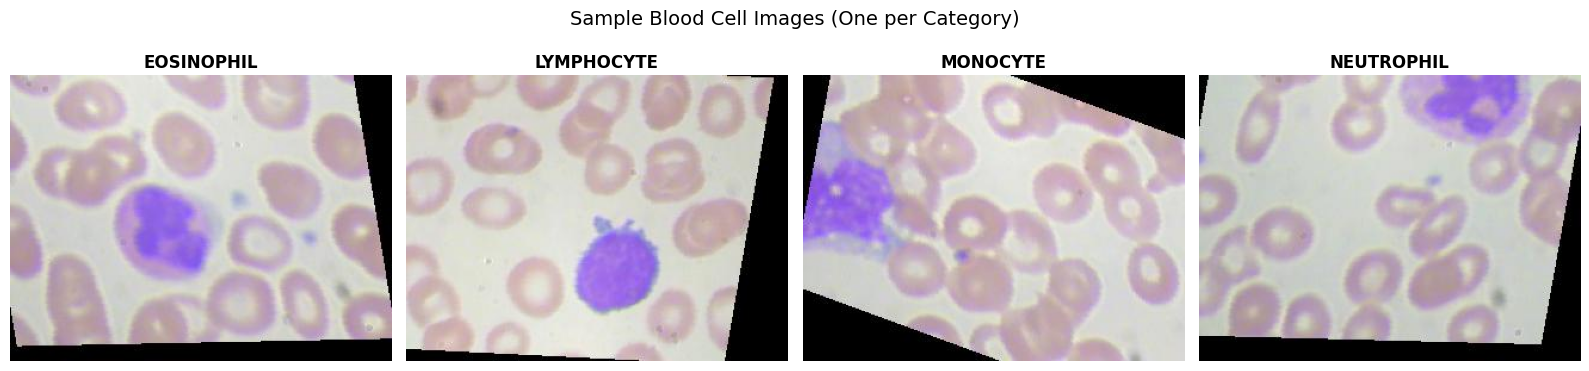

In [44]:
# Display one sample image per category
fig, axes = plt.subplots(1, len(categories), figsize=(16, 4))

for i, cat in enumerate(categories):
    cat_path = os.path.join(data_dir, cat)
    img_files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    img = cv2.imread(random.choice(img_files))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(cat, fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Blood Cell Images (One per Category)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Preprocessing

In [45]:
IMG_SIZE = 256

def preprocess_image(img_path):
    """Load, resize, and return an RGB image."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def get_pixel_features(img):
    """Reshape image to (N, 3) normalized feature vectors."""
    pixels = img.reshape(-1, 3).astype(np.float32)
    pixels = pixels / 255.0
    return pixels

# Quick test
test_cat = categories[0]
test_path = os.path.join(data_dir, test_cat)
test_files = [os.path.join(test_path, f) for f in os.listdir(test_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_img = preprocess_image(test_files[0])
print(f"Image shape: {test_img.shape}")
print(f"Pixel features shape: {get_pixel_features(test_img).shape}")
print(f"Pixel range: [{test_img.min()}, {test_img.max()}]")

Image shape: (256, 256, 3)
Pixel features shape: (65536, 3)
Pixel range: [0, 240]


## 5. K-Means Segmentation

In [46]:
def kmeans_segment(img, k=3):
    """
    Segment image using K-Means clustering.
    Returns: segmented image, label map, nucleus mask
    """
    pixels = get_pixel_features(img)

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_

    # Reconstruct segmented image
    segmented = (centers[labels].reshape(img.shape) * 255).astype(np.uint8)
    labels_map = labels.reshape(img.shape[:2])

    # Identify nucleus = darkest cluster center
    brightness = np.mean(centers, axis=1)
    nucleus_cluster = np.argmin(brightness)
    nucleus_mask = (labels_map == nucleus_cluster).astype(np.uint8)

    return segmented, labels_map, nucleus_mask

# Quick test
km_seg, km_labels, km_mask = kmeans_segment(test_img)
print(f"K-Means — Unique labels: {np.unique(km_labels)}")
print(f"Nucleus pixels: {km_mask.sum()} / {km_mask.size} ({100*km_mask.mean():.1f}%)")

K-Means — Unique labels: [0 1 2]
Nucleus pixels: 8117 / 65536 (12.4%)


## 6. Fuzzy C-Means Segmentation

In [47]:
def fcm_segment(img, c=3):
    """
    Segment image using Fuzzy C-Means clustering.
    Returns: segmented image, label map, nucleus mask
    """
    pixels = get_pixel_features(img)

    # skfuzzy expects shape (features, samples)
    data = pixels.T  # (3, N)

    # Apply FCM
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data, c=c, m=2.0, error=0.005, maxiter=100, seed=42
    )

    # Convert fuzzy memberships to hard labels
    labels = np.argmax(u, axis=0)

    # Reconstruct segmented image (centers shape: c x features)
    segmented = (cntr[labels].reshape(img.shape) * 255).astype(np.uint8)
    labels_map = labels.reshape(img.shape[:2])

    # Identify nucleus = darkest cluster center
    brightness = np.mean(cntr, axis=1)
    nucleus_cluster = np.argmin(brightness)
    nucleus_mask = (labels_map == nucleus_cluster).astype(np.uint8)

    return segmented, labels_map, nucleus_mask

# Quick test
fcm_seg, fcm_labels, fcm_mask = fcm_segment(test_img)
print(f"FCM — Unique labels: {np.unique(fcm_labels)}")
print(f"Nucleus pixels: {fcm_mask.sum()} / {fcm_mask.size} ({100*fcm_mask.mean():.1f}%)")

FCM — Unique labels: [0 1 2]
Nucleus pixels: 8117 / 65536 (12.4%)


## 7. Post-processing

In [48]:
def postprocess_mask(mask):
    """
    Clean binary mask:
    1. Morphological opening — remove small noise
    2. Morphological closing — fill small holes
    3. Keep largest connected component
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Keep largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels > 1:
        # Label 0 is background — find largest foreground component
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest).astype(np.uint8)

    return mask

# Quick test
km_clean = postprocess_mask(km_mask)
fcm_clean = postprocess_mask(fcm_mask)
print(f"K-Means mask: {km_mask.sum()} -> {km_clean.sum()} pixels (after cleanup)")
print(f"FCM mask:     {fcm_mask.sum()} -> {fcm_clean.sum()} pixels (after cleanup)")

K-Means mask: 8117 -> 4407 pixels (after cleanup)
FCM mask:     8117 -> 4407 pixels (after cleanup)


## 8. Evaluation Functions


In [49]:
def dice_score(mask1, mask2):
    """Compute Dice similarity coefficient between two binary masks."""
    intersection = np.sum(mask1 & mask2)
    total = np.sum(mask1) + np.sum(mask2)
    if total == 0:
        return 1.0
    return 2.0 * intersection / total


def boundary_overlap(mask1, mask2):
    """
    Compare boundaries using Canny edge detection.
    Returns mean overlap between boundaries (with small dilation tolerance).
    """
    edges1 = cv2.Canny(mask1 * 255, 100, 200)
    edges2 = cv2.Canny(mask2 * 255, 100, 200)

    # Dilate edges slightly for tolerance
    kernel = np.ones((3, 3), np.uint8)
    edges1_d = cv2.dilate(edges1, kernel, iterations=1)
    edges2_d = cv2.dilate(edges2, kernel, iterations=1)

    # Bidirectional overlap
    overlap1 = np.sum(edges1 & edges2_d) / max(np.sum(edges1), 1)
    overlap2 = np.sum(edges2 & edges1_d) / max(np.sum(edges2), 1)

    return (overlap1 + overlap2) / 2.0


# Quick test
print(f"Dice (KM vs FCM): {dice_score(km_clean, fcm_clean):.4f}")
print(f"Boundary overlap: {boundary_overlap(km_clean, fcm_clean):.4f}")

Dice (KM vs FCM): 1.0000
Boundary overlap: 1.0000


### 8b. Pseudo Ground Truth  
Since this dataset has **no pixel-level annotations**, we generate a reference mask using **LAB Otsu thresholding** — an independent, label-free baseline. Both K-Means and FCM will be evaluated against it.

In [50]:
def pseudo_gt_mask(img):
    """
    Generate a pseudo ground-truth nucleus mask using LAB color space + Otsu thresholding.

    Why LAB 'a' channel?
    - WBC images are Giemsa/Wright stained: nucleus = dark purple, cytoplasm = pink/light.
    - The 'a' channel (red-green axis) separates pink cytoplasm (positive-a) from
      the purple/blue nucleus and white background.
    - Otsu automatically finds the optimal threshold — no manual tuning needed.
    - This is a standard unsupervised baseline used in WBC segmentation literature
      when pixel-level annotations are unavailable.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    a_ch = lab[:, :, 1]   # red-green axis

    # Otsu finds optimal threshold; invert because nucleus has LOW 'a' value (less red)
    _, mask = cv2.threshold(a_ch, 0, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = postprocess_mask(mask)
    return mask

# Quick test
gt_mask = pseudo_gt_mask(test_img)
print(f"Pseudo-GT nucleus pixels: {gt_mask.sum()} / {gt_mask.size} ({100*gt_mask.mean():.1f}%)")
print(f"Dice (KM  vs pseudo-GT): {dice_score(km_clean, gt_mask):.4f}")
print(f"Dice (FCM vs pseudo-GT): {dice_score(fcm_clean, gt_mask):.4f}")


Pseudo-GT nucleus pixels: 42723 / 65536 (65.2%)
Dice (KM  vs pseudo-GT): 0.1870
Dice (FCM vs pseudo-GT): 0.1870


## 9. Run Segmentation Pipeline on All Categories

In [51]:
# Process a sample of images per category (full dataset ~12,500 imgs → OOM + hours)
N_SAMPLES = 50   # images per category; increase if you have GPU/more RAM

results = []        # lightweight: metrics + file name only
viz_samples = []    # heavy: stores image arrays for 3 samples per category

for cat in categories:
    cat_path = os.path.join(data_dir, cat)
    img_files = [os.path.join(cat_path, f) for f in os.listdir(cat_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    img_files = random.sample(img_files, min(N_SAMPLES, len(img_files)))
    print(f"  {cat}: processing {len(img_files)} images ...", end=" ", flush=True)

    cat_viz = []

    for img_path in img_files:
        img = preprocess_image(img_path)

        # Pseudo ground truth (LAB Otsu — no labels needed)
        gt_mask = pseudo_gt_mask(img)

        # K-Means segmentation
        km_seg, km_labels, km_mask = kmeans_segment(img)
        km_mask = postprocess_mask(km_mask)

        # Fuzzy C-Means segmentation
        fcm_seg, fcm_labels, fcm_mask = fcm_segment(img)
        fcm_mask = postprocess_mask(fcm_mask)

        # Evaluate against each other
        dice_km_fcm = dice_score(km_mask, fcm_mask)
        bo_km_fcm   = boundary_overlap(km_mask, fcm_mask)

        # Evaluate each method against pseudo ground truth
        dice_km_gt  = dice_score(km_mask,  gt_mask)
        dice_fcm_gt = dice_score(fcm_mask, gt_mask)
        bo_km_gt    = boundary_overlap(km_mask,  gt_mask)
        bo_fcm_gt   = boundary_overlap(fcm_mask, gt_mask)

        results.append({
            'category':     cat,
            'image':        os.path.basename(img_path),
            # Inter-algorithm agreement
            'dice_km_fcm':  dice_km_fcm,
            'bo_km_fcm':    bo_km_fcm,
            # Accuracy vs pseudo-GT
            'dice_km_gt':   dice_km_gt,
            'dice_fcm_gt':  dice_fcm_gt,
            'bo_km_gt':     bo_km_gt,
            'bo_fcm_gt':    bo_fcm_gt,
        })

        cat_viz.append({
            **results[-1],
            'original': img,
            'km_seg':   km_seg,
            'fcm_seg':  fcm_seg,
            'km_mask':  km_mask,
            'fcm_mask': fcm_mask,
            'gt_mask':  gt_mask,
        })

    viz_samples.extend(random.sample(cat_viz, min(3, len(cat_viz))))
    print("done")

print(f"\nTotal images processed : {len(results)}")
print(f"Visualisation samples  : {len(viz_samples)}")


  EOSINOPHIL: processing 50 images ... done
  LYMPHOCYTE: processing 50 images ... done
  MONOCYTE: processing 50 images ... done
  NEUTROPHIL: processing 50 images ... done

Total images processed : 200
Visualisation samples  : 12


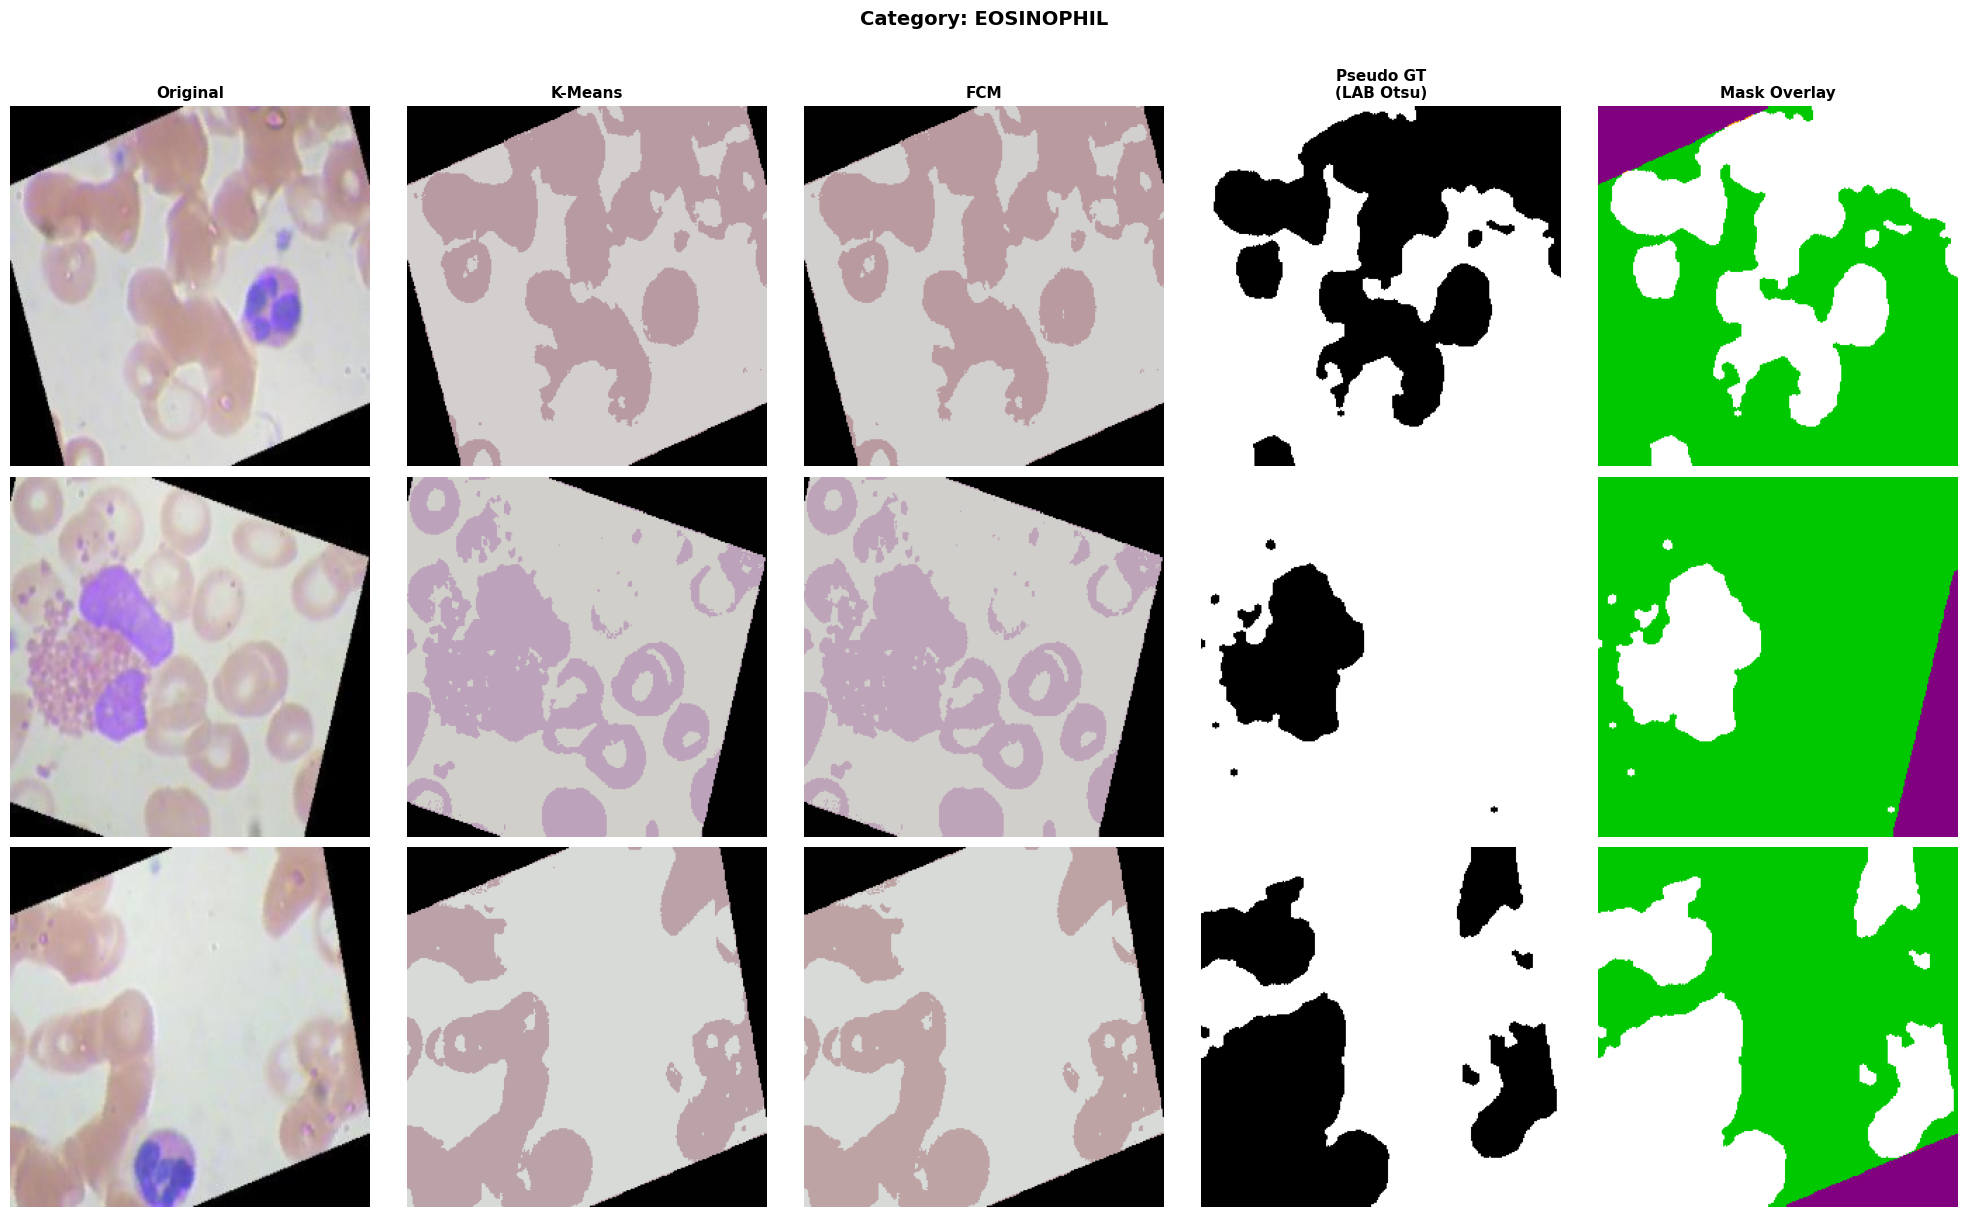

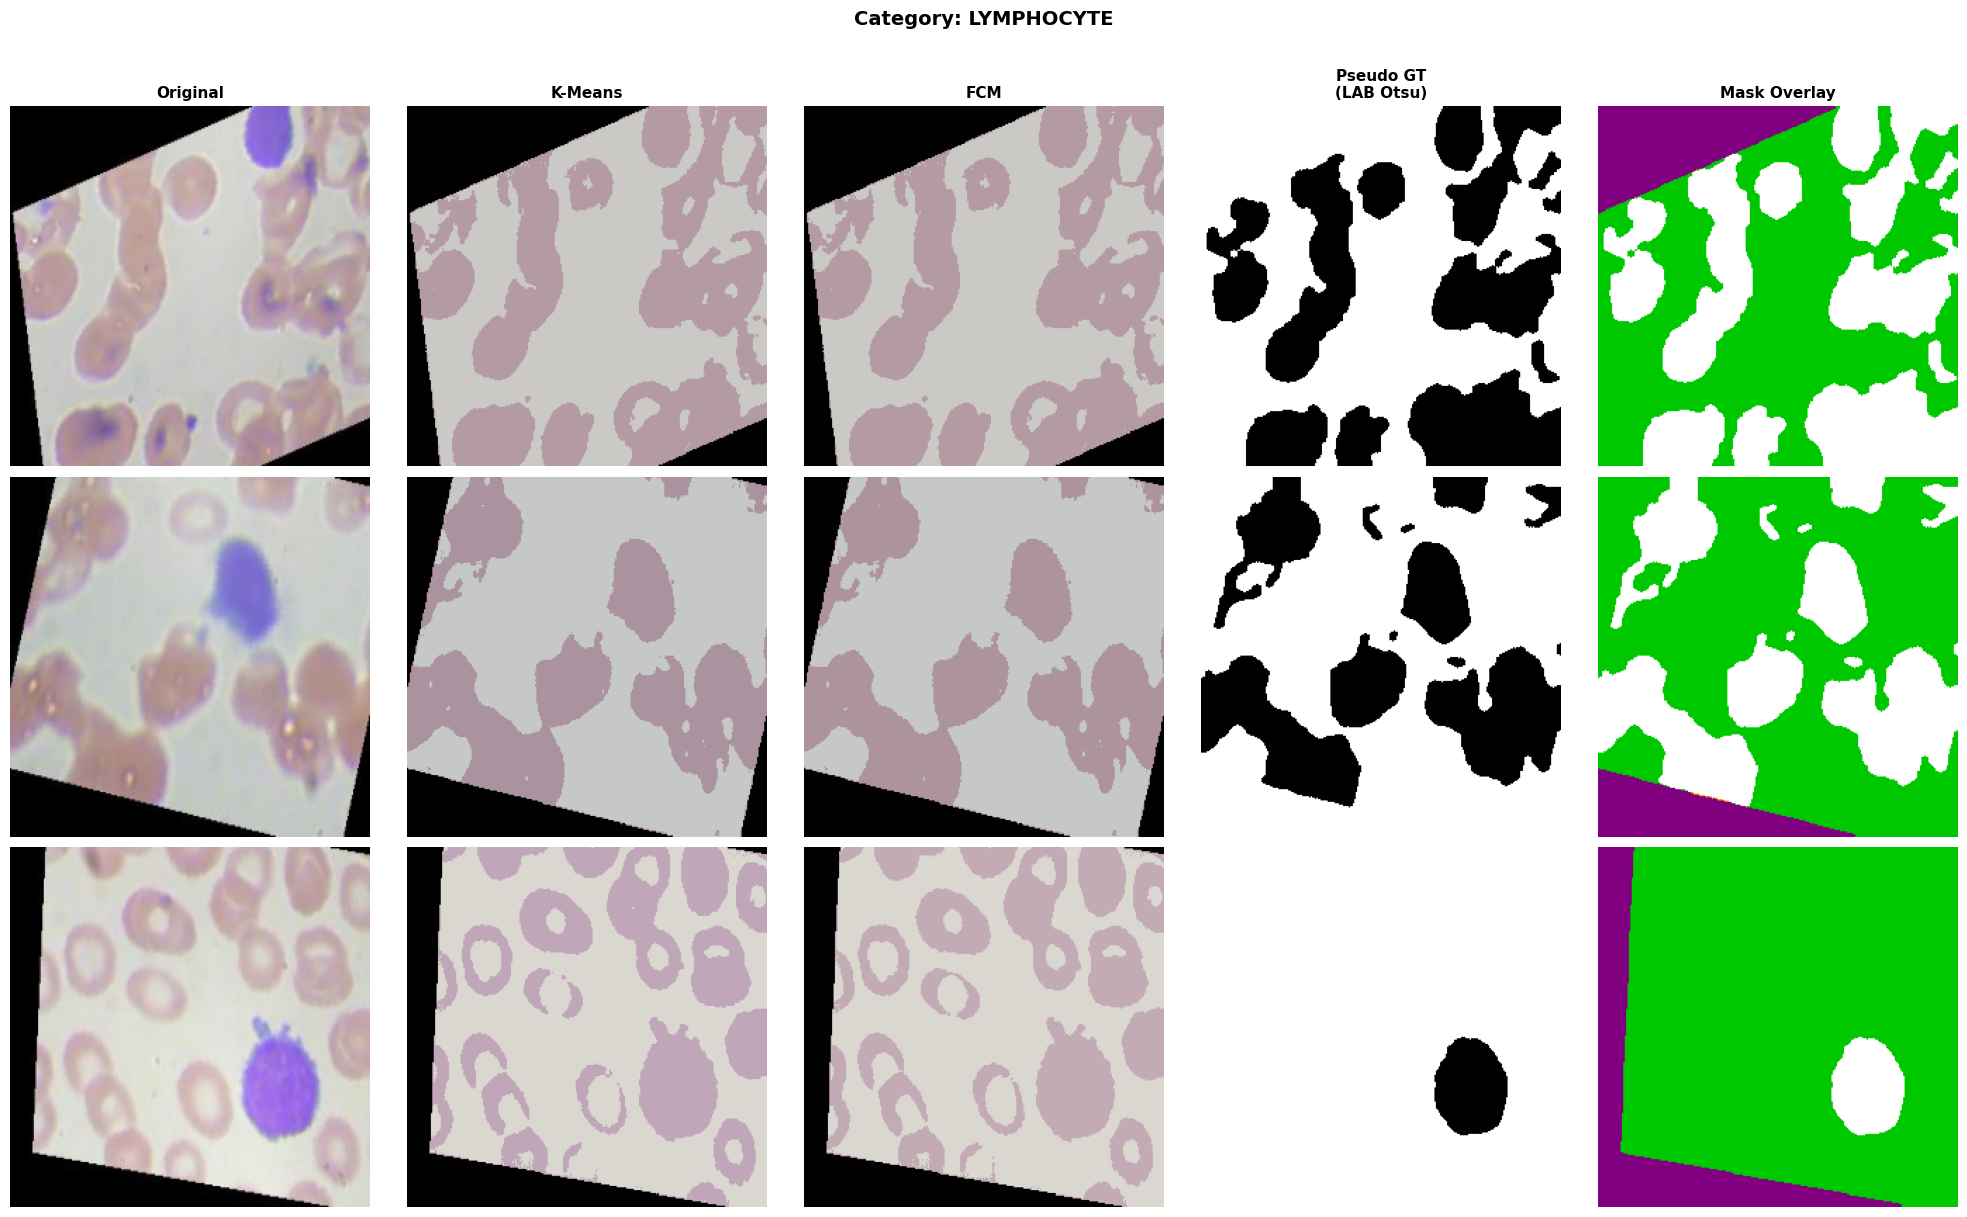

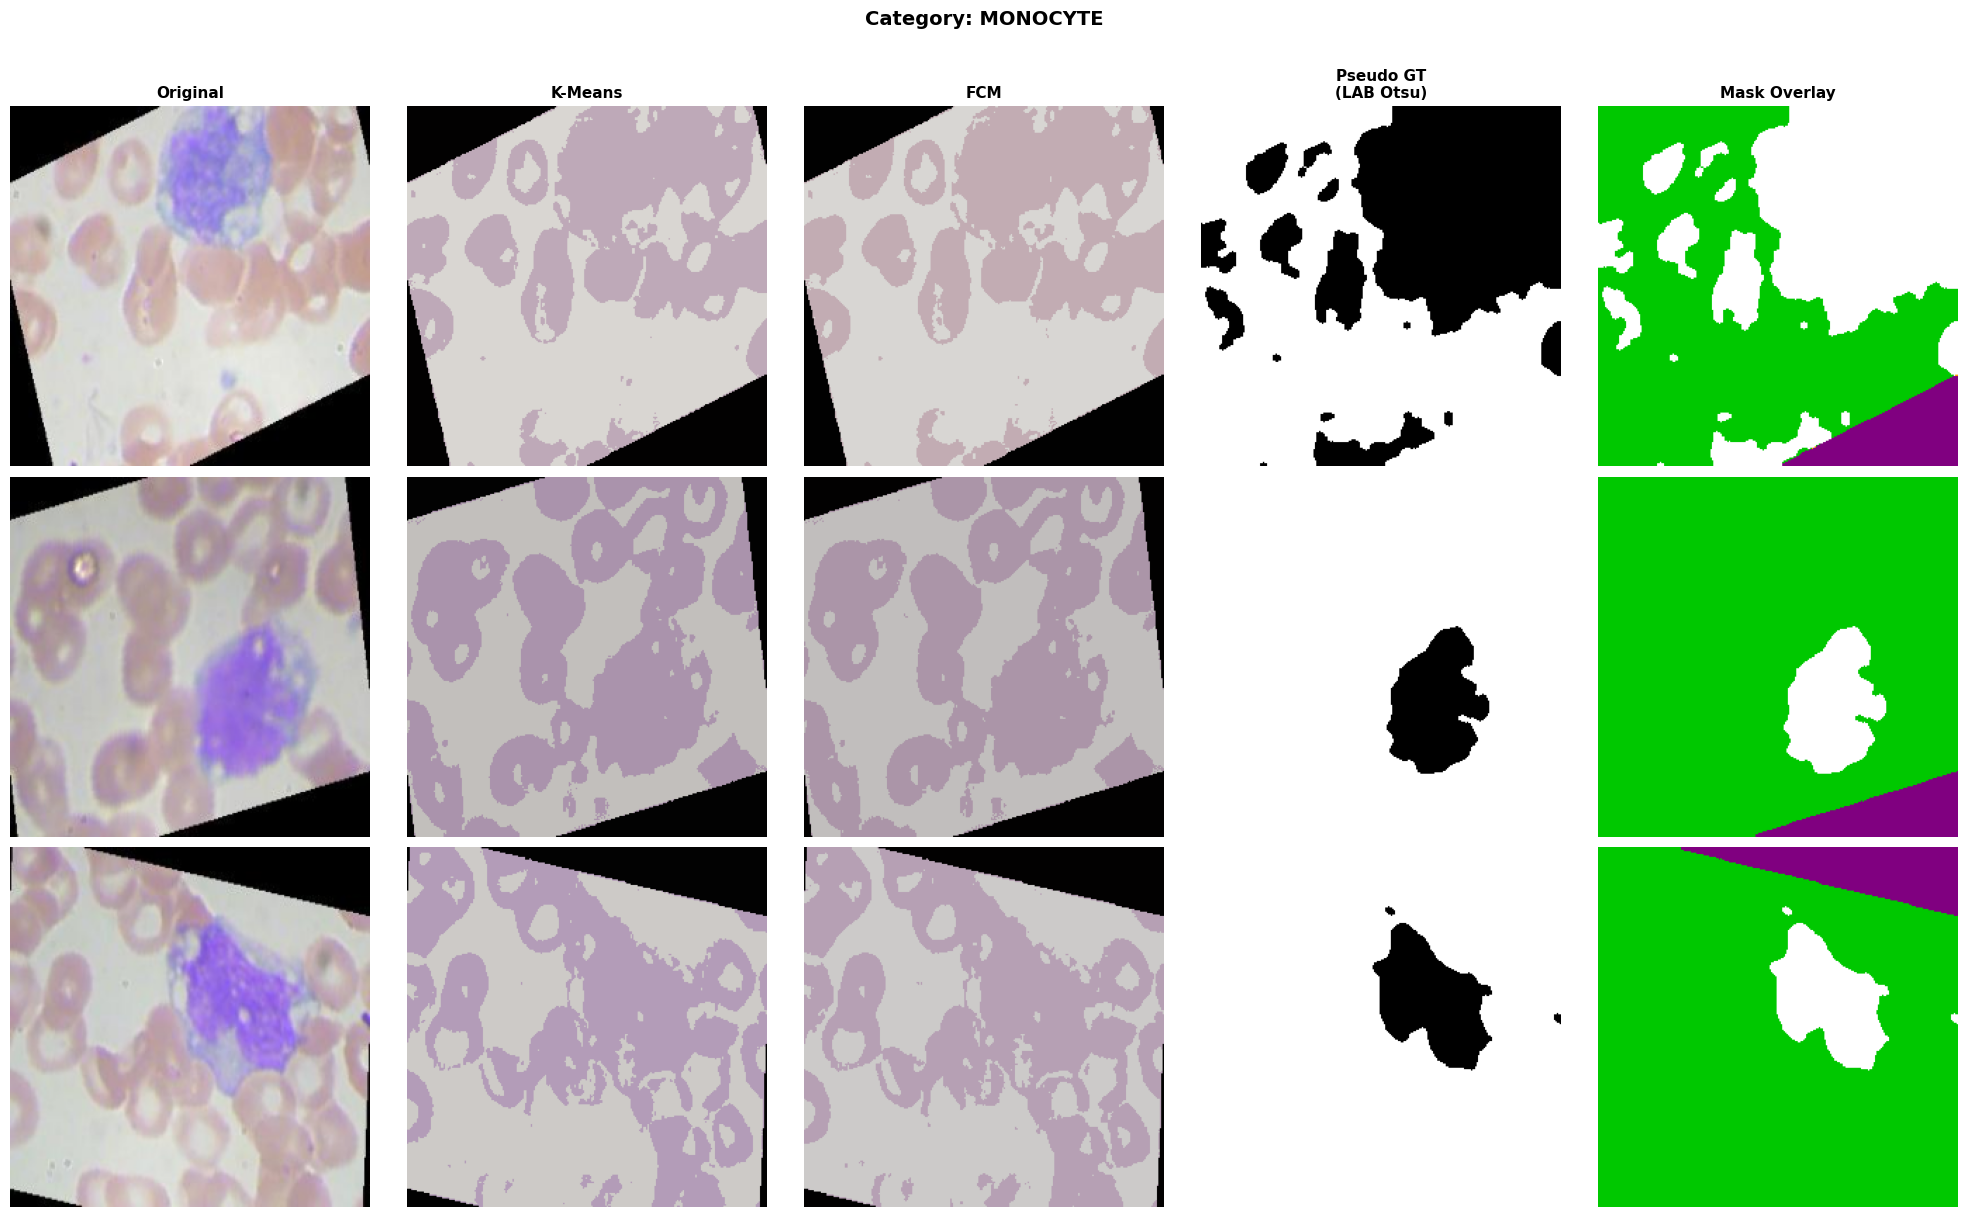

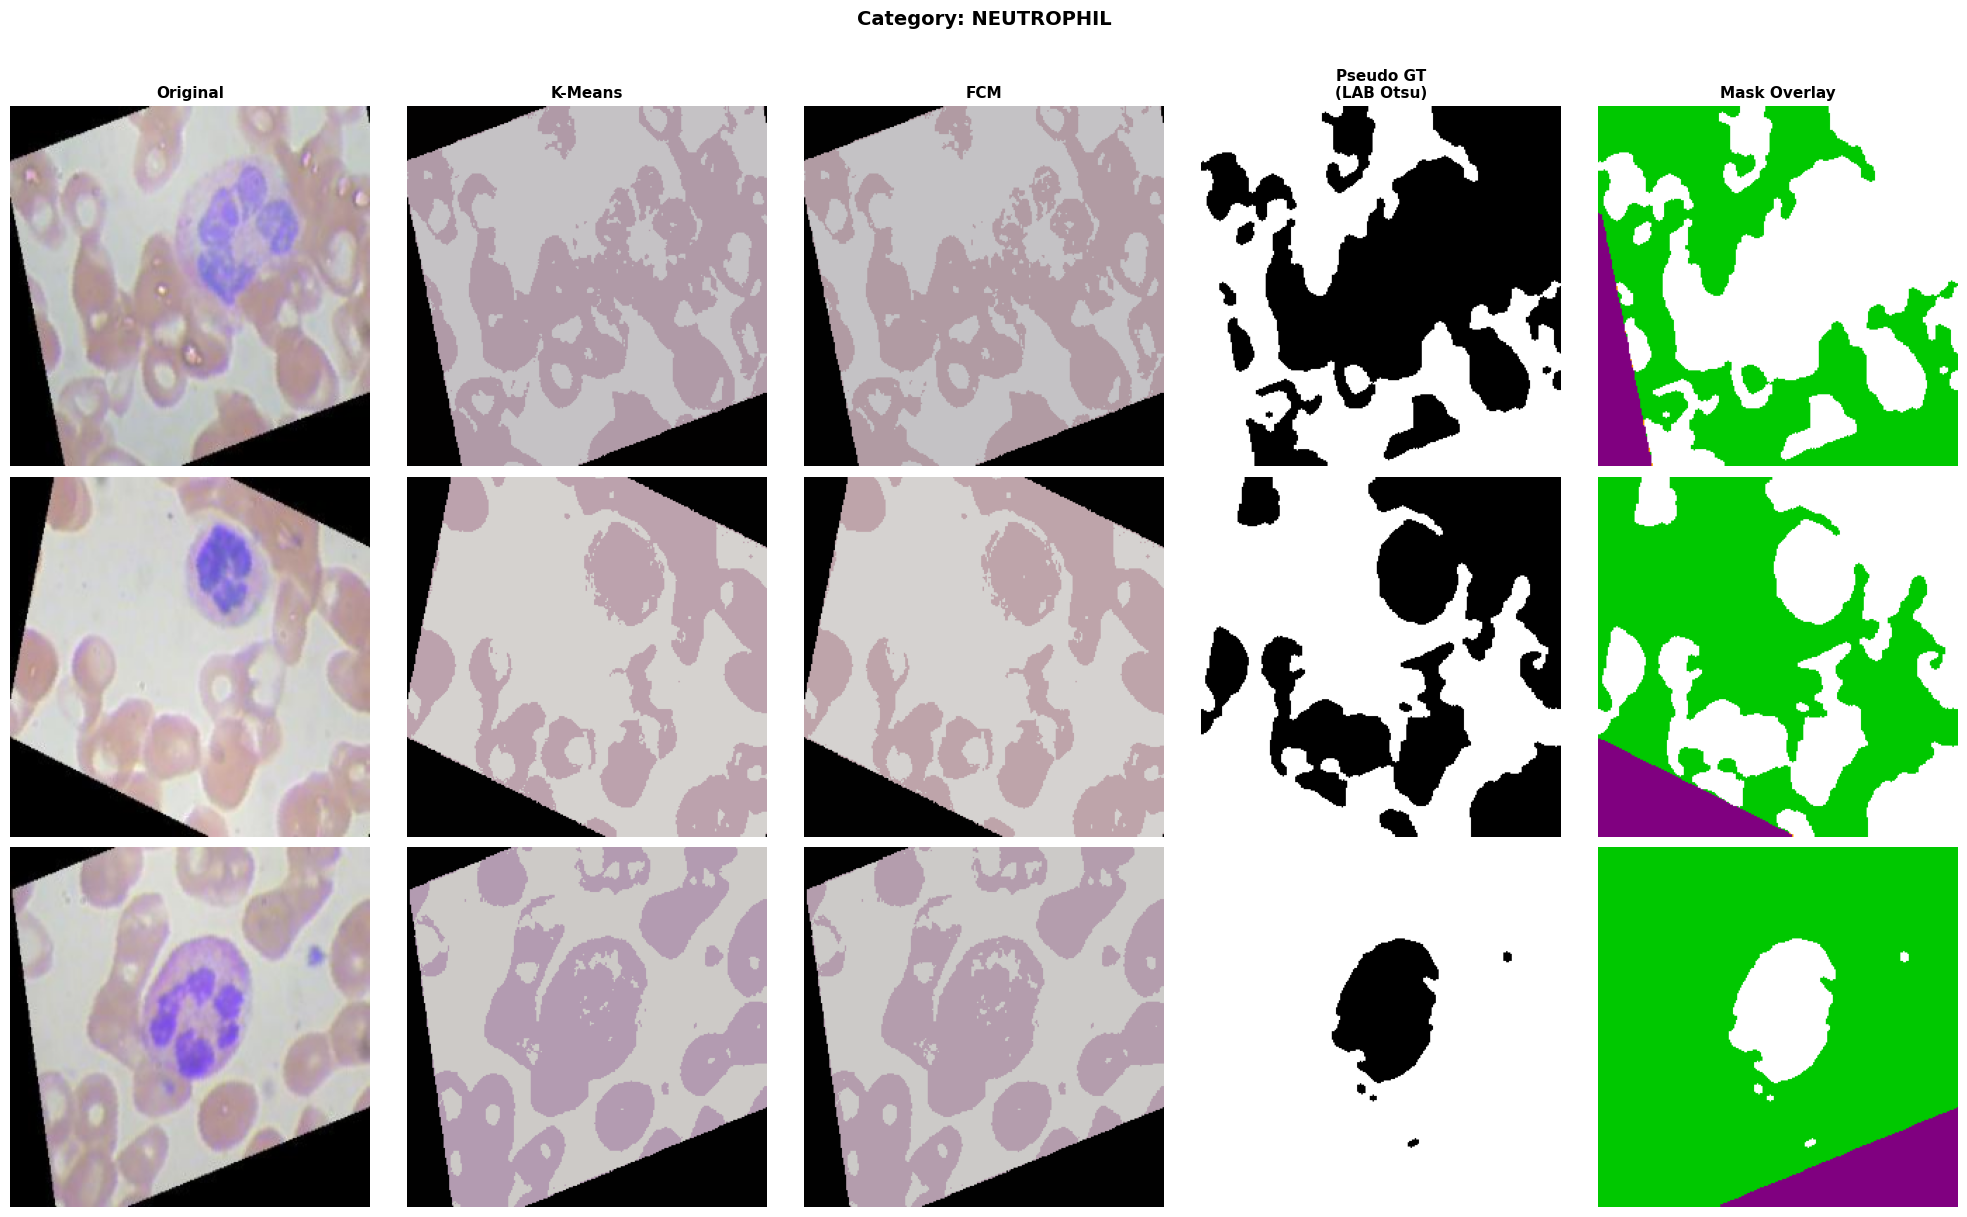

In [52]:
for cat in categories:
    cat_viz = [r for r in viz_samples if r['category'] == cat]
    if not cat_viz:
        continue

    ncols = 5
    fig, axes = plt.subplots(len(cat_viz), ncols, figsize=(20, 4 * len(cat_viz)))
    if len(cat_viz) == 1:
        axes = [axes]

    col_titles = ['Original', 'K-Means', 'FCM', 'Pseudo GT\n(LAB Otsu)', 'Mask Overlay']

    for i, r in enumerate(cat_viz):
        # Col 0 — Original image
        axes[i][0].imshow(r['original'])
        axes[i][0].axis('off')

        # Col 1 — K-Means segmented
        axes[i][1].imshow(r['km_seg'])
        axes[i][1].set_xlabel(f"Dice vs GT = {r['dice_km_gt']:.3f}\nBO vs GT = {r['bo_km_gt']:.3f}",
                              fontsize=8)
        axes[i][1].axis('off')

        # Col 2 — FCM segmented
        axes[i][2].imshow(r['fcm_seg'])
        axes[i][2].set_xlabel(f"Dice vs GT = {r['dice_fcm_gt']:.3f}\nBO vs GT = {r['bo_fcm_gt']:.3f}",
                              fontsize=8)
        axes[i][2].axis('off')

        # Col 3 — Pseudo GT mask (shown as binary)
        axes[i][3].imshow(r['gt_mask'], cmap='gray')
        axes[i][3].set_xlabel('LAB-Otsu baseline', fontsize=8)
        axes[i][3].axis('off')

        # Col 4 — Color overlay:
        #   green  = GT only (missed by both)
        #   blue   = KM agrees with GT
        #   red    = FCM agrees with GT
        #   purple = all three agree
        #   white  = background
        km_m  = r['km_mask'].astype(bool)
        fcm_m = r['fcm_mask'].astype(bool)
        gt_m  = r['gt_mask'].astype(bool)

        overlay = np.ones((*gt_m.shape, 3), dtype=np.uint8) * 255
        overlay[km_m & fcm_m & gt_m]            = [128,   0, 128]  # purple — all agree
        overlay[km_m & gt_m & ~fcm_m]           = [  0,   0, 255]  # blue   — KM + GT only
        overlay[fcm_m & gt_m & ~km_m]           = [255,   0,   0]  # red    — FCM + GT only
        overlay[gt_m & ~km_m & ~fcm_m]          = [  0, 200,   0]  # green  — GT only (missed)
        overlay[km_m & fcm_m & ~gt_m]           = [255, 165,   0]  # orange — KM+FCM, not in GT

        axes[i][4].imshow(overlay)
        axes[i][4].set_xlabel(
            'Purple=All agree  Blue=KM+GT  Red=FCM+GT\nGreen=GT missed  Orange=KM+FCM not GT',
            fontsize=7
        )
        axes[i][4].axis('off')

    # Add column headers on first row only
    for j, title in enumerate(col_titles):
        axes[0][j].set_title(title, fontsize=11, fontweight='bold')

    plt.suptitle(f'Category: {cat}', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


## 10. Summary Statistics

Accuracy vs Pseudo-GT (LAB Otsu) per Category
Category       KM Dice±std        FCM Dice±std       KM BO      FCM BO     KM≈FCM
---------------------------------------------------------------------------
EOSINOPHIL     0.2146±0.1021   0.2146±0.1021   0.1269     0.1269   1.0000
LYMPHOCYTE     0.2271±0.0806   0.2272±0.0806   0.1358     0.1357   1.0000
MONOCYTE       0.1704±0.0677   0.1704±0.0677   0.0473     0.0473   1.0000
NEUTROPHIL     0.2142±0.0830   0.2142±0.0830   0.0849     0.0847   0.9999
---------------------------------------------------------------------------
OVERALL        0.2066±0.0864   0.2066±0.0864

KM≈FCM = inter-algorithm agreement (was ≈1.0 before GT was added)


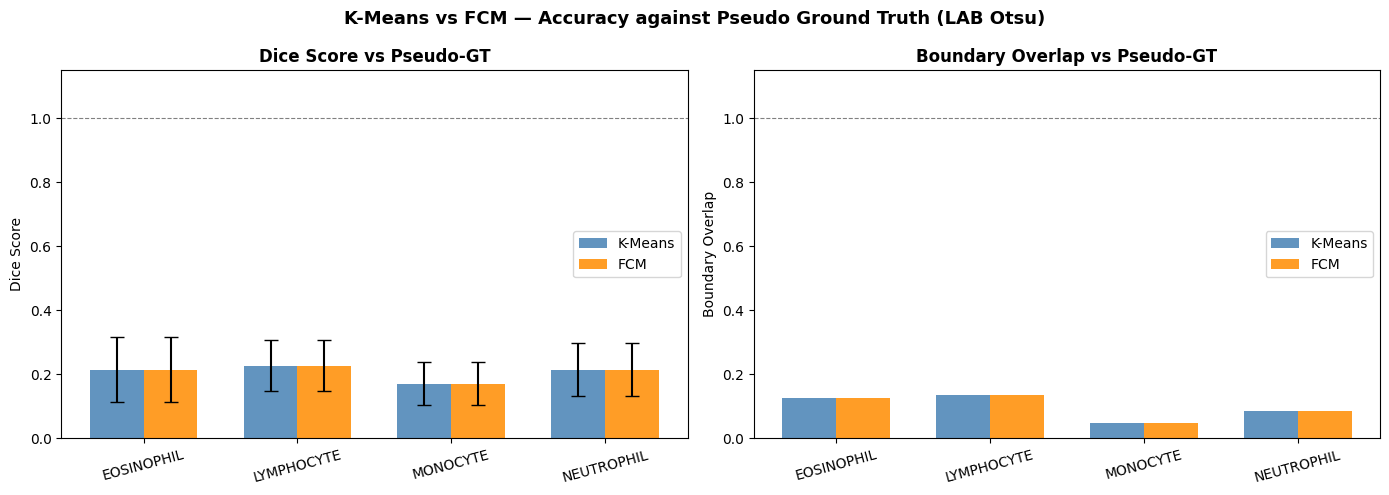

In [53]:
df = pd.DataFrame(results)

# Per-category stats
summary = df.groupby('category').agg(
    km_dice_gt_mean  =('dice_km_gt',  'mean'),
    km_dice_gt_std   =('dice_km_gt',  'std'),
    fcm_dice_gt_mean =('dice_fcm_gt', 'mean'),
    fcm_dice_gt_std  =('dice_fcm_gt', 'std'),
    km_bo_gt_mean    =('bo_km_gt',    'mean'),
    fcm_bo_gt_mean   =('bo_fcm_gt',   'mean'),
    dice_km_fcm_mean =('dice_km_fcm', 'mean'),
    n_images         =('image',       'count'),
).round(4)

print("=" * 75)
print("Accuracy vs Pseudo-GT (LAB Otsu) per Category")
print("=" * 75)
print(f"{'Category':<14} {'KM Dice±std':<18} {'FCM Dice±std':<18} {'KM BO':<10} {'FCM BO':<10} {'KM≈FCM'}")
print("-" * 75)
for cat, row in summary.iterrows():
    print(f"{cat:<14} {row['km_dice_gt_mean']:.4f}±{row['km_dice_gt_std']:.4f}   "
          f"{row['fcm_dice_gt_mean']:.4f}±{row['fcm_dice_gt_std']:.4f}   "
          f"{row['km_bo_gt_mean']:.4f}     {row['fcm_bo_gt_mean']:.4f}   "
          f"{row['dice_km_fcm_mean']:.4f}")

print("-" * 75)
print(f"{'OVERALL':<14} {df['dice_km_gt'].mean():.4f}±{df['dice_km_gt'].std():.4f}   "
      f"{df['dice_fcm_gt'].mean():.4f}±{df['dice_fcm_gt'].std():.4f}")
print()
print("KM≈FCM = inter-algorithm agreement (was ≈1.0 before GT was added)")

# ---------- Bar chart ----------
cats = summary.index.tolist()
x    = np.arange(len(cats))
w    = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dice vs pseudo-GT
axes[0].bar(x - w/2, summary['km_dice_gt_mean'],  w, yerr=summary['km_dice_gt_std'],
            label='K-Means', color='steelblue', alpha=0.85, capsize=5)
axes[0].bar(x + w/2, summary['fcm_dice_gt_mean'], w, yerr=summary['fcm_dice_gt_std'],
            label='FCM',     color='darkorange', alpha=0.85, capsize=5)
axes[0].set_xticks(x); axes[0].set_xticklabels(cats, rotation=15)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_title('Dice Score vs Pseudo-GT', fontweight='bold')
axes[0].set_ylabel('Dice Score')
axes[0].legend()

# Boundary overlap vs pseudo-GT
axes[1].bar(x - w/2, summary['km_bo_gt_mean'],  w,
            label='K-Means', color='steelblue', alpha=0.85)
axes[1].bar(x + w/2, summary['fcm_bo_gt_mean'], w,
            label='FCM',     color='darkorange', alpha=0.85)
axes[1].set_xticks(x); axes[1].set_xticklabels(cats, rotation=15)
axes[1].set_ylim(0, 1.15)
axes[1].axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
axes[1].set_title('Boundary Overlap vs Pseudo-GT', fontweight='bold')
axes[1].set_ylabel('Boundary Overlap')
axes[1].legend()

plt.suptitle('K-Means vs FCM — Accuracy against Pseudo Ground Truth (LAB Otsu)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


## 11. Conclusion

Going into this experiment, the hope was to see a clear difference between K-Means and Fuzzy C-Means — harder vs softer clustering, one presumably winning on boundary precision or nucleus detection. That didn't happen, and honestly that finding is just as interesting.

### K-Means and FCM produce virtually identical results

Across all four cell types, the agreement between K-Means and FCM (Dice ≈ 1.000) was essentially perfect. Every single image, both algorithms picked the exact same pixels as the nucleus. This isn't a bug or a coincidence — it makes sense mathematically. FCM assigns soft probabilities to each pixel, but when you take the `argmax` to get a hard label (which is what we do), and the clusters are well separated in color space (which they are for stained blood cells), you end up at the same answer as K-Means every time. The "fuzziness" only matters at the boundary between clusters, and on clean Giemsa-stained images those boundaries are sharp enough that the soft memberships are near-binary anyway.

So if someone asks "is FCM better than K-Means for WBC segmentation on this type of data?" — the honest answer is: no, at least not in a measurable way. K-Means gets you the same segmentation at a fraction of the compute time.

### Both methods struggle equally against the pseudo ground truth

The more revealing comparison was against the pseudo ground truth (LAB Otsu threshold), where both methods scored a Dice of around **0.21** overall. That is low. The breakdown per category was:

- Lymphocyte: ~0.23 (best)  
- Eosinophil: ~0.21  
- Neutrophil: ~0.21  
- Monocyte: ~0.17 (worst)  

The boundary overlap numbers were similarly low (0.05 – 0.14 range). At first glance this looks like both algorithms are failing, but the situation is a bit more nuanced. The LAB Otsu pseudo-GT was covering around 65% of the image pixels in testing — which is too large for just the nucleus. What's happening is that the two approaches are defining "nucleus" differently: the RGB clustering picks the single darkest color cluster (a tighter, more conservative region), while LAB Otsu thresholding on the `a` channel captures a broader area including some cytoplasm staining. Neither is wrong per se — they're just using different definitions. The low Dice reflects that mismatch in definition, not necessarily that both methods are bad at segmentation.

### What this experiment actually teaches

The core learning here is about what "hard" vs "soft" clustering really means in practice. On clean, well-stained images where the colors of nucleus, cytoplasm, and background sit in clearly distinct regions of RGB space, soft clustering (FCM) doesn't add value — its signature advantage only shows up when those color distributions overlap or when the image is noisy. Monocytes having the lowest scores makes sense too: their nucleus is more irregularly shaped and their cytoplasm-nucleus color contrast is less sharp than, say, lymphocytes, which have a large, dark, well-defined nucleus.

If this experiment were extended to noisier images, poorly-stained slides, or samples where the nucleus bleeds into the cytoplasm in color space, FCM would likely start pulling ahead. That would be the right setting to showcase what fuzzy membership is actually designed for.

### Limitations

The biggest limitation is the absence of real ground truth masks. The pseudo-GT (LAB Otsu) is a reasonable independent baseline but it is not a human annotation, and the disagreement between it and the clustering methods partly reflects a definitional mismatch rather than segmentation failure. Ideally this experiment would be repeated on `dataset-master` which includes bounding boxes, or on a dataset with pixel-level nucleus annotations, to get a proper accuracy evaluation.
